# Imports

In [1]:
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score, precision_score, recall_score
)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours, RandomUnderSampler
from imblearn.over_sampling import SMOTE

os.environ['LOKY_MAX_CPU_COUNT'] = '4'


In [2]:
# Define the data types as a dictionary
dtypes = {
    'action_taken': 'int32',
    'loan_type': 'int32',
    'lien_status': 'int32',
    'open_end_line_of_credit': 'int32',
    'loan_amount': 'int32',
    'combined_loan_to_value_ratio': 'int32',
    'interest_rate': 'float32',
    'total_loan_costs': 'float32',
    'origination_charges': 'float32',
    'loan_term': 'float32',
    'negative_amortization': 'int32',
    'interest_only_payment': 'int32',
    'balloon_payment': 'int32',
    'other_nonamortizing_features': 'int32',
    'property_value': 'float32',
    'occupancy_type': 'int32',
    'manufactured_home_secured_property_type': 'int32',
    'manufactured_home_land_property_interest': 'int32',
    'total_units': 'int32',
    'income': 'float32',
    'debt_to_income_ratio': 'float32',
    'applicant_credit_score_type': 'int32',
    'co_applicant_credit_score_type': 'int32',
    'applicant_ethnicity_1': 'float32',
    'co_applicant_ethnicity_1': 'float32',
    'applicant_race_1': 'float32',
    'applicant_race_2': 'float32',
    'co_applicant_race_1': 'float32',
    'co_applicant_race_2': 'float32',
    'applicant_sex': 'int32',
    'co_applicant_sex': 'int32',
    'applicant_age': 'int32',
    'co_applicant_age': 'int32',
}

In [3]:
# Read the CSV file with specified data types
df = pd.read_csv('10_all_numerical_32bit.csv', dtype=dtypes, low_memory=False)

# Drop the column you want to exclude
column_to_exclude = 'reverse_mortgage'
if column_to_exclude in df:
    df.drop(column_to_exclude, axis=1, inplace=True)

# Convert the data types of the remaining columns as needed
df = df.astype(dtypes)

# The order of the columns

In [4]:
accepted_rows = df[df['action_taken'] == 1].head(3)  # Select the first 3 rows
column_order = accepted_rows.columns.tolist()
print(column_order)

['action_taken', 'loan_type', 'lien_status', 'open_end_line_of_credit', 'loan_amount', 'combined_loan_to_value_ratio', 'interest_rate', 'total_loan_costs', 'origination_charges', 'loan_term', 'negative_amortization', 'interest_only_payment', 'balloon_payment', 'other_nonamortizing_features', 'property_value', 'occupancy_type', 'manufactured_home_secured_property_type', 'manufactured_home_land_property_interest', 'total_units', 'income', 'debt_to_income_ratio', 'applicant_credit_score_type', 'co_applicant_credit_score_type', 'applicant_ethnicity_1', 'co_applicant_ethnicity_1', 'applicant_race_1', 'applicant_race_2', 'co_applicant_race_1', 'co_applicant_race_2', 'applicant_sex', 'co_applicant_sex', 'applicant_age', 'co_applicant_age']


# Three rows where action_taken  == 1

In [5]:
# Extract the values as a list of dictionaries
accepted_values = accepted_rows.to_dict(orient='records')
accepted_values

[{'action_taken': 1,
  'loan_type': 1,
  'lien_status': 1,
  'open_end_line_of_credit': 2,
  'loan_amount': 305000,
  'combined_loan_to_value_ratio': 2,
  'interest_rate': 6.0,
  'total_loan_costs': 6.0,
  'origination_charges': 3.0,
  'loan_term': 6.0,
  'negative_amortization': 2,
  'interest_only_payment': 2,
  'balloon_payment': 2,
  'other_nonamortizing_features': 2,
  'property_value': 415000.0,
  'occupancy_type': 1,
  'manufactured_home_secured_property_type': 3,
  'manufactured_home_land_property_interest': 5,
  'total_units': 1,
  'income': 171.0,
  'debt_to_income_ratio': 3.0,
  'applicant_credit_score_type': 1,
  'co_applicant_credit_score_type': 9,
  'applicant_ethnicity_1': 2.0,
  'co_applicant_ethnicity_1': 2.0,
  'applicant_race_1': 5.0,
  'applicant_race_2': 5.0,
  'co_applicant_race_1': 5.0,
  'co_applicant_race_2': 5.0,
  'applicant_sex': 1,
  'co_applicant_sex': 2,
  'applicant_age': 1,
  'co_applicant_age': 1},
 {'action_taken': 1,
  'loan_type': 1,
  'lien_status'

In [6]:
# Now, convert the list of dictionaries into an array
accepted_array = [list(row.values()) for row in accepted_values]

# Print the resulting array
print(accepted_array)

[[1, 1, 1, 2, 305000, 2, 6.0, 6.0, 3.0, 6.0, 2, 2, 2, 2, 415000.0, 1, 3, 5, 1, 171.0, 3.0, 1, 9, 2.0, 2.0, 5.0, 5.0, 5.0, 5.0, 1, 2, 1, 1], [1, 1, 1, 2, 715000, 8, 4.0, 8.0, 5.0, 6.0, 2, 2, 2, 2, 1135000.0, 1, 3, 5, 1, 267.0, 3.0, 3, 9, 2.0, 2.0, 5.0, 5.0, 5.0, 5.0, 1, 2, 1, 0], [1, 1, 1, 2, 205000, 3, 6.0, 2.0, 6.0, 6.0, 2, 2, 2, 2, 205000.0, 1, 3, 5, 1, 54.0, 4.0, 2, 9, 1.0, 1.0, 5.0, 5.0, 5.0, 5.0, 1, 2, 0, 6]]


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54832 entries, 0 to 54831
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   action_taken                              54832 non-null  int32  
 1   loan_type                                 54832 non-null  int32  
 2   lien_status                               54832 non-null  int32  
 3   open_end_line_of_credit                   54832 non-null  int32  
 4   loan_amount                               54832 non-null  int32  
 5   combined_loan_to_value_ratio              54832 non-null  int32  
 6   interest_rate                             54832 non-null  float32
 7   total_loan_costs                          54832 non-null  float32
 8   origination_charges                       54832 non-null  float32
 9   loan_term                                 54832 non-null  float32
 10  negative_amortization             

# Correlations

In [8]:
df.corr()

,action_taken,loan_type,lien_status,open_end_line_of_credit,loan_amount,combined_loan_to_value_ratio,interest_rate,total_loan_costs,origination_charges,loan_term,...,applicant_ethnicity_1,co_applicant_ethnicity_1,applicant_race_1,applicant_race_2,co_applicant_race_1,co_applicant_race_2,applicant_sex,co_applicant_sex,applicant_age,co_applicant_age
action_taken,1.000000,0.033010,0.046155,-0.056097,-0.057184,0.087122,-0.155858,0.186395,-0.536480,-0.002293,...,-0.104207,-0.104662,-0.120259,0.009716,-0.117366,-0.000553,0.066813,-0.062197,0.065491,0.069521
loan_type,0.033010,1.000000,-0.035303,0.013596,-0.092368,0.015203,-0.007852,0.176211,-0.021591,0.115278,...,-0.012535,-0.019958,-0.047721,-0.001133,-0.043853,-0.008053,-0.031338,0.035467,0.021975,0.017844
lien_status,0.046155,-0.035303,1.000000,-0.282540,-0.108907,0.067024,0.105814,0.016203,-0.078760,-0.245511,...,-0.006579,-0.007714,-0.003441,-0.006094,0.000180,-0.006401,0.019085,-0.014057,-0.028679,-0.017450
open_end_line_of_credit,-0.056097,0.013596,-0.282540,1.000000,0.036093,-0.013756,0.008743,-0.010456,0.030095,0.050448,...,-0.006663,-0.005788,-0.001766,0.002285,-0.000289,0.002186,-0.011234,0.000095,0.001856,0.005106
loan_amount,-0.057184,-0.092368,-0.108907,0.036093,1.000000,-0.048889,-0.242229,0.099897,-0.042362,0.212943,...,0.077007,0.076777,0.069941,0.004531,0.070330,0.011851,-0.106991,0.089784,-0.062263,-0.082055
combined_loan_to_value_ratio,0.087122,0.015203,0.067024,-0.013756,-0.048889,1.000000,-0.083003,-0.031639,-0.048333,-0.138304,...,-0.036703,-0.038047,-0.004547,-0.000244,-0.003413,-0.003006,-0.012246,0.013430,0.149632,0.140888
interest_rate,-0.155858,-0.007852,0.105814,0.008743,-0.242229,-0.083003,1.000000,-0.100541,0.114960,0.123701,...,-0.034055,-0.031053,-0.013860,0.002808,-0.012512,-0.002890,0.034588,-0.032981,0.024206,0.033350
total_loan_costs,0.186395,0.176211,0.016203,-0.010456,0.099897,-0.031639,-0.100541,1.000000,0.099968,0.091775,...,-0.035141,-0.033498,-0.030759,-0.002068,-0.029505,0.000408,-0.000977,0.001787,-0.047943,-0.042582
origination_charges,-0.536480,-0.021591,-0.078760,0.030095,-0.042362,-0.048333,0.114960,0.099968,1.000000,-0.024807,...,0.038199,0.038271,0.069685,-0.007895,0.068115,-0.002563,-0.024129,0.024293,-0.014165,-0.012539
loan_term,-0.002293,0.115278,-0.245511,0.050448,0.212943,-0.138304,0.123701,0.091775,-0.024807,1.000000,...,-0.005349,-0.001973,0.005164,0.009848,0.004124,0.010153,-0.030769,0.026906,-0.053871,-0.041721


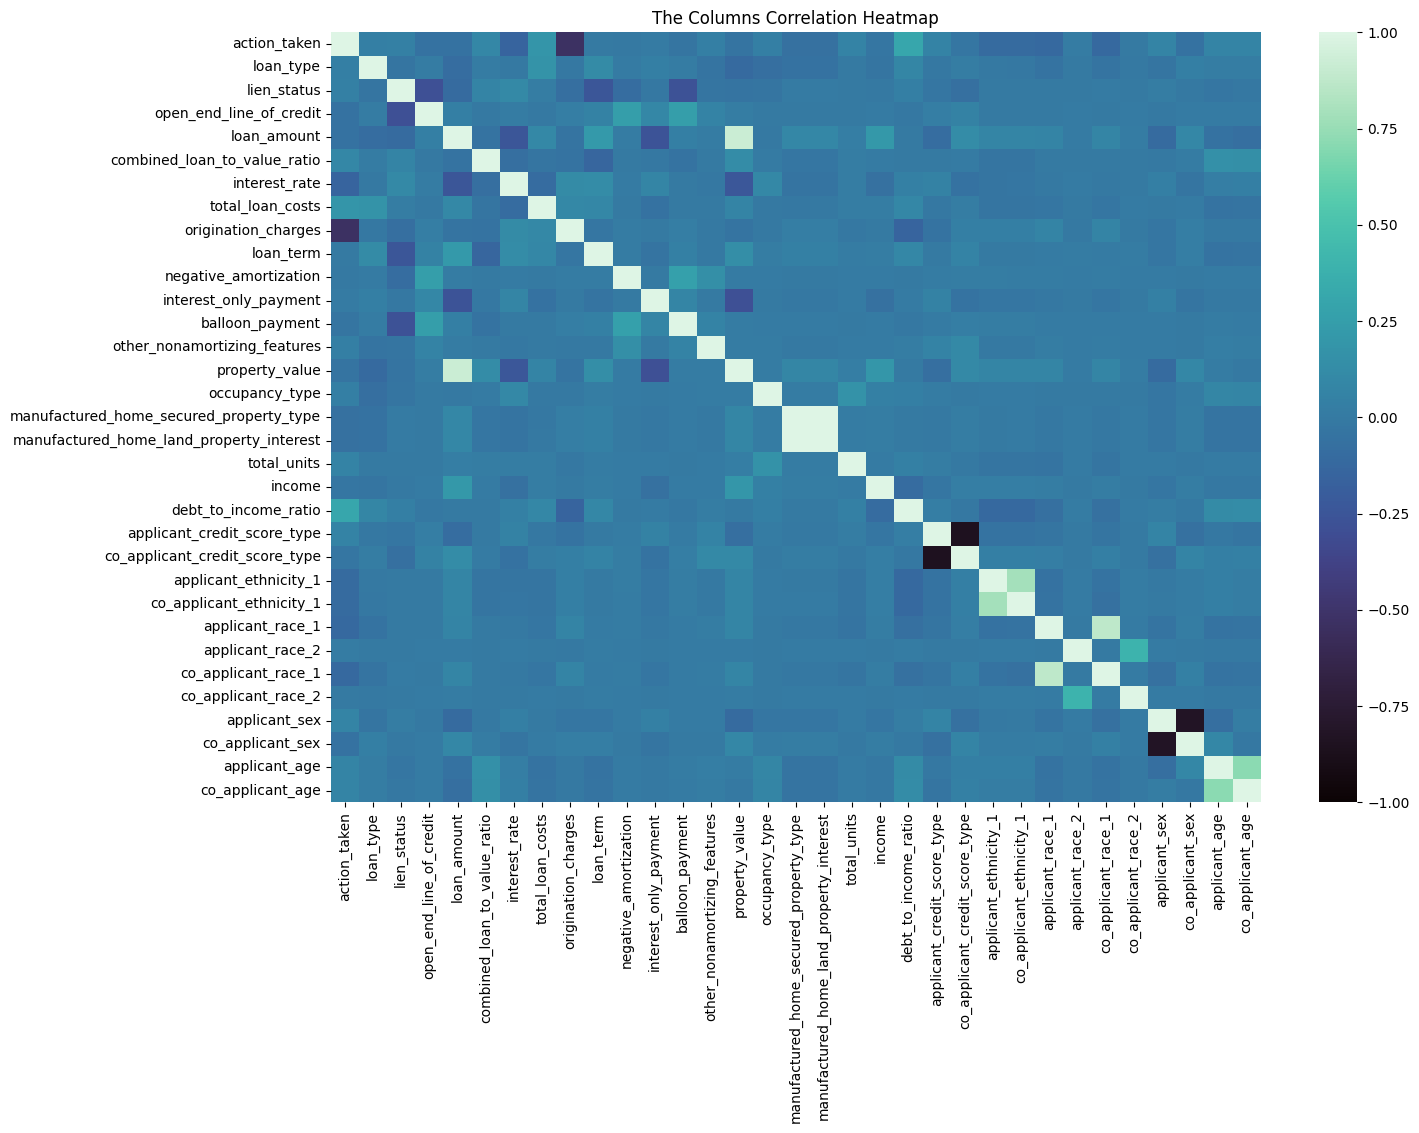

In [9]:
plt.figure(figsize=(15,10))
plt.title('The Columns Correlation Heatmap')
sns.heatmap(df.corr(),cmap='mako', annot=False, vmin=-1, vmax=1);

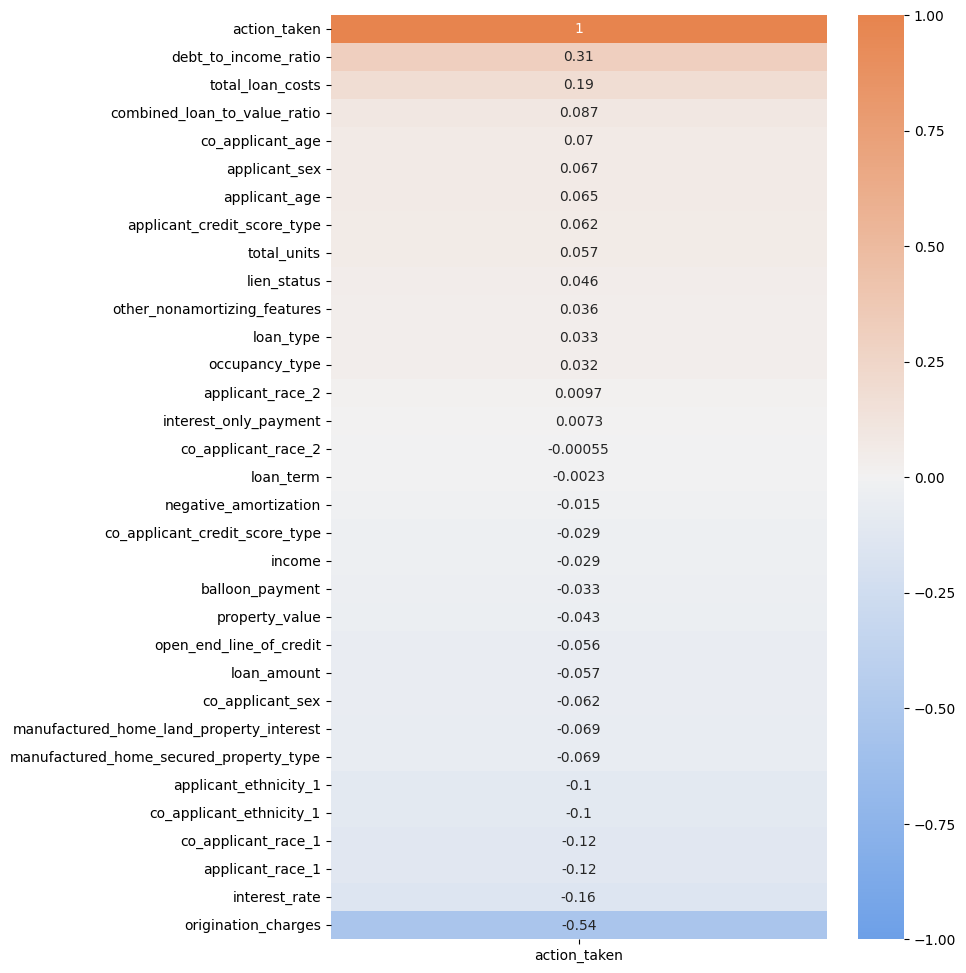

In [10]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['action_taken']].sort_values(by='action_taken', ascending=False), vmin=-1, vmax=1, annot=True, cmap=sns.diverging_palette(250, 30, l=65, as_cmap=True))

In [11]:
print(df['action_taken'].value_counts())

action_taken
1    31034
3    23798
Name: count, dtype: int64


In [12]:
# Specify the conditions for the columns and values
conditions = {
    'applicant_age': 1,
    'applicant_race_2': 5.0,
    'co_applicant_ethnicity_1': 2.0,
    'co_applicant_race_1': 5.0,
    'co_applicant_race_2': 5.0,
}

# Create a mask for filtering rows based on conditions
mask = [True] * len(df)

for column, value in conditions.items():
    if isinstance(value, tuple):
        mask = mask & ((df[column] >= value[0]) & (df[column] <= value[1]))
    else:
        mask = mask & (df[column] == value)

# Use the mask to filter the DataFrame and retrieve the specific record
specific_records_df = df[mask]

# Check if there are any matching records
if not specific_records_df.empty:
    # Print the first matching record
    specific_record_df = specific_records_df.iloc[3]

    # Create a DataFrame from the data
    table_df = pd.DataFrame(specific_record_df)

    # Display the table
    print(table_df)
    
else:
    print("No matching record found.")

                                                25
action_taken                                   3.0
loan_type                                      2.0
lien_status                                    1.0
open_end_line_of_credit                        2.0
loan_amount                               335000.0
combined_loan_to_value_ratio                  10.0
interest_rate                                  5.0
total_loan_costs                               7.0
origination_charges                            1.0
loan_term                                      6.0
negative_amortization                          2.0
interest_only_payment                          2.0
balloon_payment                                2.0
other_nonamortizing_features                   2.0
property_value                            415000.0
occupancy_type                                 1.0
manufactured_home_secured_property_type        3.0
manufactured_home_land_property_interest       5.0
total_units                    

C:\Users\asche\AppData\Local\Temp\ipykernel_3820\506278063.py:17: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  mask = mask & (df[column] == value)


In [13]:
specific_row = df.iloc[25:26]  # Extract the 26th row (index 25) as a DataFrame

# Create X and y

In [14]:
X = df.drop('action_taken', axis=1)
y = df['action_taken']

In [15]:
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic regression

In [16]:
# Train a logistic regression model on the resampled training data
model1 = LogisticRegression(max_iter=1000)
model1.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [17]:
# Make predictions on the test set
y_pred1 = model1.predict(X_test)

In [18]:
# Calculate and print the classification report
report1 = classification_report(y_test, y_pred1, zero_division=1)

print(report1)

              precision    recall  f1-score   support

           1       0.57      0.99      0.72      6189
           3       0.64      0.02      0.05      4778

    accuracy                           0.57     10967
   macro avg       0.60      0.51      0.38     10967
weighted avg       0.60      0.57      0.43     10967



# Save datasets - scaled and unscaled.

In [19]:
df.to_csv('final_dataset.csv', index=False)

In [20]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
X = df_scaled.drop('action_taken', axis=1)
y = df_scaled['action_taken']
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
df_scaled.to_csv('scaled_final_dataset.csv', index=False)

In [22]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54832 entries, 0 to 54831
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   action_taken                              54832 non-null  float64
 1   loan_type                                 54832 non-null  float64
 2   lien_status                               54832 non-null  float64
 3   open_end_line_of_credit                   54832 non-null  float64
 4   loan_amount                               54832 non-null  float64
 5   combined_loan_to_value_ratio              54832 non-null  float64
 6   interest_rate                             54832 non-null  float64
 7   total_loan_costs                          54832 non-null  float64
 8   origination_charges                       54832 non-null  float64
 9   loan_term                                 54832 non-null  float64
 10  negative_amortization             

# Logistic regression after scaling with regularisation

In [23]:
# Create a regularized logistic regression model with L2 regularization
model3 = LogisticRegression(penalty='l2', C=1.0 ,max_iter=1000)

# Fit the model on the resampled training data
model3.fit(X_train, y_train)

# Make predictions on the test set
y_pred3 = model3.predict(X_test)

# Calculate and print the classification report
report3 = classification_report(y_test, y_pred3, zero_division=1)
print(report3)

              precision    recall  f1-score   support

         0.0       0.94      0.80      0.87      6189
         1.0       0.78      0.93      0.85      4778

    accuracy                           0.86     10967
   macro avg       0.86      0.87      0.86     10967
weighted avg       0.87      0.86      0.86     10967



# SMOTE-ENN (Synthetic Minority Over-sampling Technique - Edited Nearest Neighbors): 
    
This technique first oversamples the minority class using SMOTE and then removes 
noisy samples by applying Edited Nearest Neighbors (ENN) to the combined dataset. 
It's a good choice if you suspect that there are noisy samples in your majority class 
that you want to remove.

In [24]:
# Create a SMOTE-ENN instance
smote_enn = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))

# Fit and resample your training data
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# Create a regularized logistic regression model with L2 regularization
logistic_reg_smote = LogisticRegression(penalty='l2', C=1.0, max_iter=1000)

# Fit the model on the resampled training data
logistic_reg_smote.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_prob = logistic_reg_smote.predict_proba(X_test)[:, 1]

# Calculate and print the classification report
report = classification_report(y_test, (y_prob > 0.5).astype(int), zero_division=1)
print(report)

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_prob)
print("AUC-ROC:", roc_auc)

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_prob, pos_label=1)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)

              precision    recall  f1-score   support

         0.0       1.00      0.74      0.85      6189
         1.0       0.75      1.00      0.86      4778

    accuracy                           0.85     10967
   macro avg       0.87      0.87      0.85     10967
weighted avg       0.89      0.85      0.85     10967

AUC-ROC: 0.9219194575558074
Precision-Recall AUC: 0.851394297620538


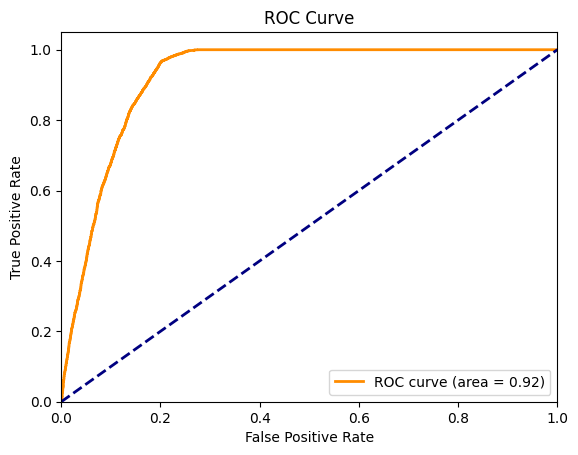

In [25]:
# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR)
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)

# Calculate AUC-ROC
roc_auc = auc(fpr, tpr)

# Create the ROC curve plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


# SMOTE-ENN  with selected columns

In [26]:
df_scaled['applicant_sex'].value_counts()

applicant_sex
0.0    39558
0.2    15221
0.4       27
1.0       26
Name: count, dtype: int64

In [27]:
# Define the minority classes for each column
minority_classes = {
    'applicant_sex': [0.2, 1.0, 0.4],
    'co_applicant_sex': [0.0, 1.0],
    'applicant_race_1': [0.0],
    'co_applicant_race_1': [0.0],
    'applicant_ethnicity_1': [0.0],
    'co_applicant_ethnicity_1': [0.0],
}

# Create a dictionary to store resampled datasets for each column
resampled_datasets = {}

# Iterate through the columns and apply SMOTE to each
for column, minority_class in minority_classes.items():
    # Select the specific column
    selected_column = df_scaled[column].values.reshape(-1, 1)

    # Define y_min based on the minority class for this column
    y_min = [1 if value in minority_class else 0 for value in df_scaled[column]]

    # Apply SMOTE to the selected column
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled2, y_resampled2 = smote.fit_resample(selected_column, y_min)

    # Store the resampled data in the dictionary
    resampled_datasets[column] = (X_resampled2, y_resampled2)


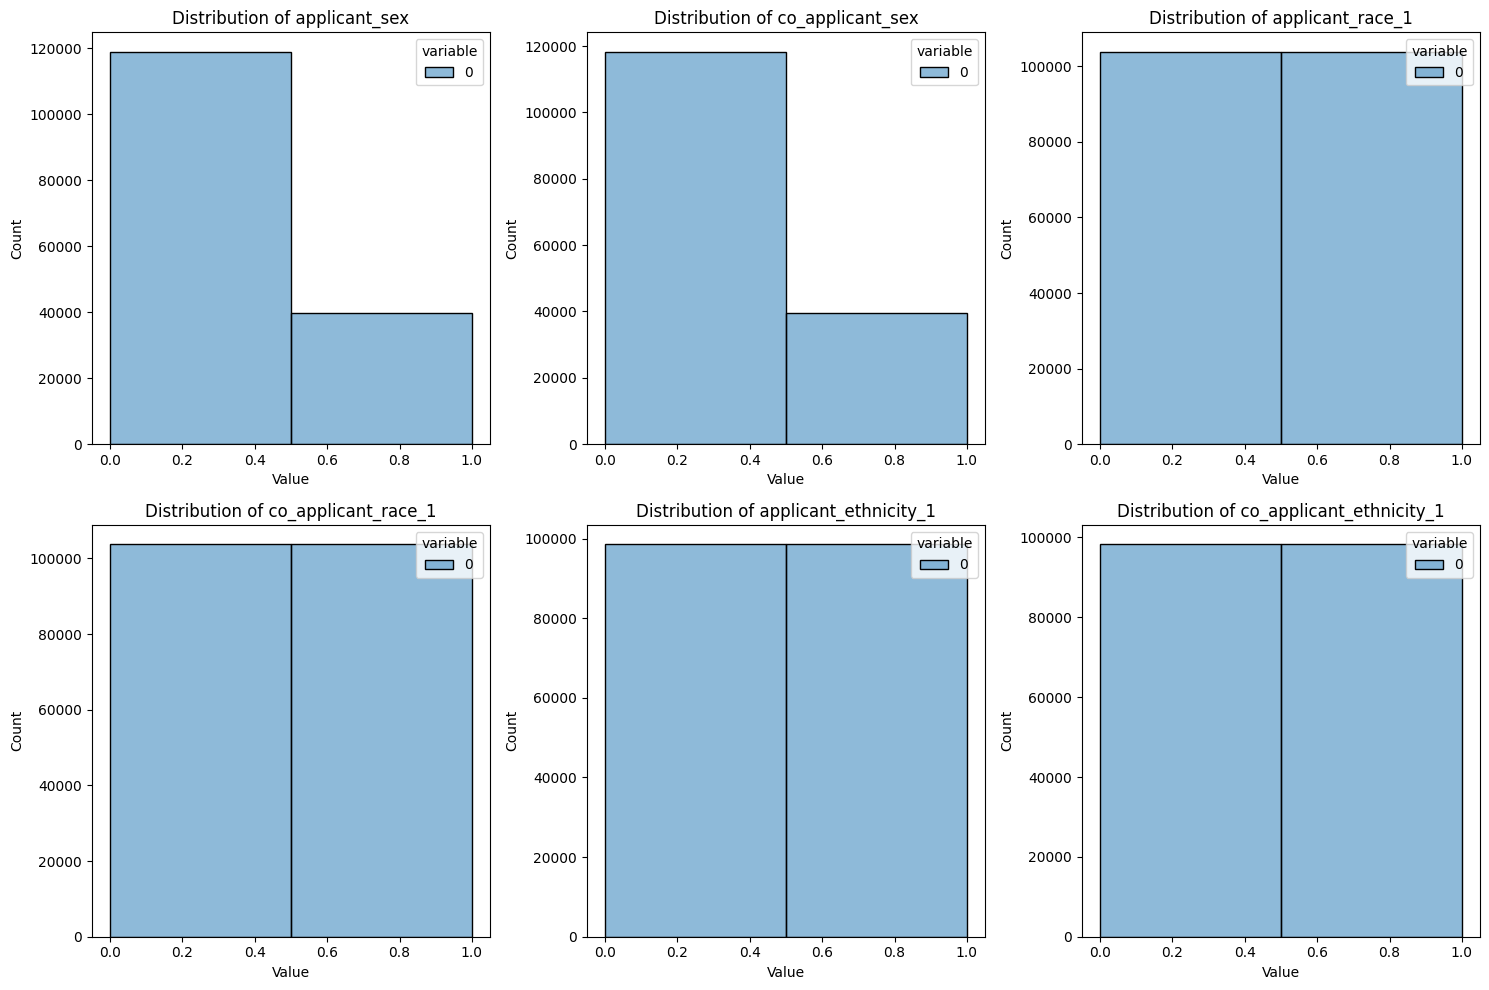

In [28]:
# Create a grid of histograms with 3 plots on every row
columns_to_plot = list(resampled_datasets.keys())

num_plots = len(columns_to_plot)
num_rows = (num_plots // 3) + (num_plots % 3)
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
axes = axes.ravel()

for i, column in enumerate(columns_to_plot):
    X_resampled2, y_resampled2 = resampled_datasets[column]

    merged_data = pd.concat([pd.DataFrame(X_resampled2), pd.DataFrame(y_resampled2)], axis=1)

    g = sns.histplot(data=merged_data.melt(), x='value', hue='variable', binwidth=0.5, ax=axes[i])
    g.set_title(f'Distribution of {column}')
    g.set_xlabel("Value")
    g.set_ylabel("Count")

# Hide any empty subplots
for i in range(num_plots, num_rows * 3):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [29]:
X_resampled2.shape

(98240, 1)

In [30]:
# X_resampled2

In [31]:
# X_resampled2

In [32]:
# Convert the list to a NumPy array
y_resampled2 = np.array(y_resampled2)

# Now you can access the shape
print(y_resampled2.shape)

(98240,)


In [33]:
y_resampled2

array([0, 0, 0, ..., 1, 1, 1])

In [34]:
# Create a SMOTE-ENN instance
smote_enn = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))

# Fit and resample your training data
X_resampled2, y_resampled2 = smote_enn.fit_resample(X_train, y_train)

# Create a regularized logistic regression model with L2 regularization
logistic_reg_smote = LogisticRegression(penalty='l2', C=10, max_iter=10000)

# Fit the model on the resampled training data
logistic_reg_smote.fit(X_resampled2, y_resampled2)

# Make predictions on the test set
y_prob = logistic_reg_smote.predict_proba(X_test)[:, 1]

# Calculate and print the classification report
report = classification_report(y_test, (y_prob > 0.5).astype(int), zero_division=1)
print(report)

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_prob)
print("AUC-ROC:", roc_auc)

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_prob, pos_label=1)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)


              precision    recall  f1-score   support

         0.0       1.00      0.76      0.86      6189
         1.0       0.76      1.00      0.86      4778

    accuracy                           0.86     10967
   macro avg       0.88      0.88      0.86     10967
weighted avg       0.89      0.86      0.86     10967

AUC-ROC: 0.9204306361608766
Precision-Recall AUC: 0.8379528176282862


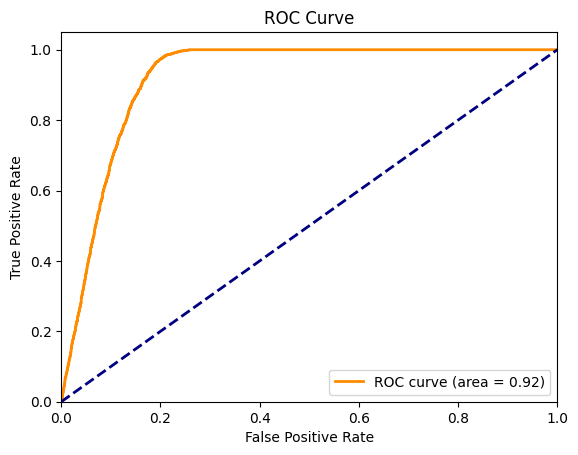

In [35]:
# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR)
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)

# Calculate AUC-ROC
roc_auc = auc(fpr, tpr)

# Create the ROC curve plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [36]:
'''

# Define a grid of hyperparameters to search over
param_grid = {
    'penalty': ['l2', None],
    'C': [10, 100, 1000, 10000],  # Regularization strength
    'max_iter': [1000, 5000, 10000, 50000, 100000]  # Maximum number of iterations
}

# Filter out warnings related to logistic regression
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.linear_model")


# Create a logistic regression model
logistic_reg = LogisticRegression()

# Initialize variables for early stopping
best_auc = -1  # Initialize with a value that's guaranteed to be less than any valid AUC-ROC score
max_patience = 5  # Maximum number of consecutive iterations without improvement before early stopping
patience = 0

for _ in range(50):  # Perform up to 50 iterations
    # Create a GridSearchCV instance with 5-fold cross-validation
    grid_search = GridSearchCV(logistic_reg, param_grid, scoring='roc_auc', cv=5)

    # Fit the grid search to the resampled training data
    grid_search.fit(X_resampled2, y_resampled2)

    # Get the mean AUC-ROC score from cross-validation
    mean_auc = np.mean(grid_search.cv_results_['mean_test_score'])
    
    if mean_auc > best_auc:
        best_auc = mean_auc
        best_params = grid_search.best_params_
        patience = 0  # Reset patience if there's an improvement
    else:
        patience += 1
    
    if patience >= max_patience:
        print("Early stopping: No improvement for {} iterations.".format(max_patience))
        break

# Get the best hyperparameters found
print("Best Hyperparameters:", best_params)

# Create the best model with the best hyperparameters
best_model = LogisticRegression(**best_params)

# Fit the best model to the resampled training data
best_model.fit(X_resampled2, y_resampled2)

# Make predictions on the test set using the best model
y_prob = best_model.predict_proba(X_test)[:, 1]

# Calculate and print the classification report
report = classification_report(y_test, (y_prob > 0.5).astype(int), zero_division=1)
print(report)

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_prob)
print("AUC-ROC:", roc_auc)

'''

'\n\n# Define a grid of hyperparameters to search over\nparam_grid = {\n    \'penalty\': [\'l2\', None],\n    \'C\': [10, 100, 1000, 10000],  # Regularization strength\n    \'max_iter\': [1000, 5000, 10000, 50000, 100000]  # Maximum number of iterations\n}\n\n# Filter out warnings related to logistic regression\nwarnings.filterwarnings("ignore", category=UserWarning, module="sklearn.linear_model")\n\n\n# Create a logistic regression model\nlogistic_reg = LogisticRegression()\n\n# Initialize variables for early stopping\nbest_auc = -1  # Initialize with a value that\'s guaranteed to be less than any valid AUC-ROC score\nmax_patience = 5  # Maximum number of consecutive iterations without improvement before early stopping\npatience = 0\n\nfor _ in range(50):  # Perform up to 50 iterations\n    # Create a GridSearchCV instance with 5-fold cross-validation\n    grid_search = GridSearchCV(logistic_reg, param_grid, scoring=\'roc_auc\', cv=5)\n\n    # Fit the grid search to the resampled trai

Best Hyperparameters: {'C': 10000, 'max_iter': 1000, 'penalty': 'l2'}

In [37]:
'''

# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR)
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)


# Calculate AUC-ROC
roc_auc = auc(fpr, tpr)

# Create the ROC curve plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

'''

'\n\n# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR)\nfpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)\n\n\n# Calculate AUC-ROC\nroc_auc = auc(fpr, tpr)\n\n# Create the ROC curve plot\nplt.figure()\nplt.plot(fpr, tpr, color=\'darkorange\', lw=2, label=\'ROC curve (area = %0.2f)\' % roc_auc)\nplt.plot([0, 1], [0, 1], color=\'navy\', lw=2, linestyle=\'--\')\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.05])\nplt.xlabel(\'False Positive Rate\')\nplt.ylabel(\'True Positive Rate\')\nplt.title(\'ROC Curve\')\nplt.legend(loc="lower right")\nplt.show()\n\n'

# Final logistic model

In [38]:
# Create a SMOTE-ENN instance
smote_enn = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))

# Fit and resample your training data
X_resampled2, y_resampled2 = smote_enn.fit_resample(X_train, y_train)

# Create a regularized logistic regression model with L2 regularization
logistic_reg_smote = LogisticRegression(C=10000, max_iter=1000, penalty='l2')

# Fit the model on the resampled training data
logistic_reg_smote.fit(X_resampled2, y_resampled2)

# Make predictions on the test set
y_prob = logistic_reg_smote.predict_proba(X_test)[:, 1]

# Calculate and print the classification report
report = classification_report(y_test, (y_prob > 0.5).astype(int), zero_division=1)
print(report)

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_prob)
print("AUC-ROC:", roc_auc)

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_prob, pos_label=1)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)


              precision    recall  f1-score   support

         0.0       1.00      0.76      0.86      6189
         1.0       0.76      1.00      0.86      4778

    accuracy                           0.86     10967
   macro avg       0.88      0.88      0.86     10967
weighted avg       0.89      0.86      0.86     10967

AUC-ROC: 0.9192767370186009
Precision-Recall AUC: 0.833113760180956


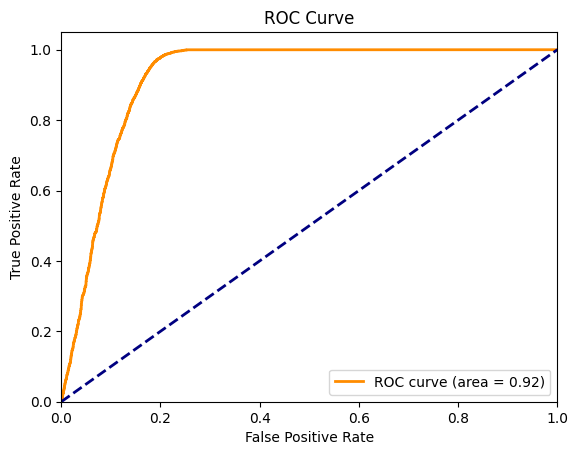

In [39]:
# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR)
fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=1)

# Calculate AUC-ROC
roc_auc = auc(fpr, tpr)

# Create the ROC curve plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# XGBoost (eXtreme Gradient Boosting) 

In [40]:
# Define your hyperparameters
params = {
    'colsample_bytree': 0.7,
    'eval_metric': 'logloss',  # Specify eval_metric during initialization
    'learning_rate': 0.3,
    'max_depth': 3,
    'min_child_weight': 1,
    'missing': -999,
    'n_estimators': 8000,
    'nthread': 4,
    'objective': 'binary:logistic',
    'seed': 1337,
    'subsample': 0.9
}

## Make a validation data set

In [41]:
# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Split X_train and y_train into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [42]:
# Define and initialize the XGBoost classifier
xgb_model = XGBClassifier(**params, early_stopping_rounds=3)

# Set the validation dataset for early stopping
eval_set = [(X_val, y_val)]

In [43]:
# Train the model and monitor early stopping
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# Make predictions on the test set
y_predict = (xgb_model.predict_proba(X_test)[:, 1] >= 0.59)

# Calculate precision and recall on the test set
precision = precision_score(y_test, y_predict)
recall = recall_score(y_test, y_predict)

# Print test set results
print("Test set results:")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

from sklearn.metrics import accuracy_score, f1_score

# Calculate other evaluation metrics
accuracy = accuracy_score(y_test, y_predict)
f1 = f1_score(y_test, y_predict)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Print other evaluation metrics
print("Test set results:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

[0]	validation_0-logloss:0.48830
[1]	validation_0-logloss:0.38185
[2]	validation_0-logloss:0.27772
[3]	validation_0-logloss:0.24530
[4]	validation_0-logloss:0.19299
[5]	validation_0-logloss:0.17112
[6]	validation_0-logloss:0.14029
[7]	validation_0-logloss:0.11994
[8]	validation_0-logloss:0.10667
[9]	validation_0-logloss:0.09748
[10]	validation_0-logloss:0.09024
[11]	validation_0-logloss:0.08512
[12]	validation_0-logloss:0.08165
[13]	validation_0-logloss:0.07828
[14]	validation_0-logloss:0.07582
[15]	validation_0-logloss:0.07402
[16]	validation_0-logloss:0.07194
[17]	validation_0-logloss:0.07042
[18]	validation_0-logloss:0.06928
[19]	validation_0-logloss:0.06799
[20]	validation_0-logloss:0.06667
[21]	validation_0-logloss:0.06608
[22]	validation_0-logloss:0.06549
[23]	validation_0-logloss:0.06476
[24]	validation_0-logloss:0.06419
[25]	validation_0-logloss:0.06370
[26]	validation_0-logloss:0.06310
[27]	validation_0-logloss:0.06268
[28]	validation_0-logloss:0.06241
[29]	validation_0-loglos

## Summary Results

High Precision and Recall: A high precision (0.9727) and recall (0.9991) indicate that the model is making accurate positive predictions and correctly identifying almost all actual positive instances. This suggests that the model generalizes well to unseen data.

High Accuracy: An accuracy of 0.9874 means the model is making correct predictions for a large majority of instances, which is another indicator of good generalization.

High F1 Score: The F1 score, which balances precision and recall, is also high at 0.9857, further indicating the model's strong performance.

Confusion Matrix: The confusion matrix shows a low number of false positives (121) and false negatives (4), which is a good sign of a well-calibrated model.

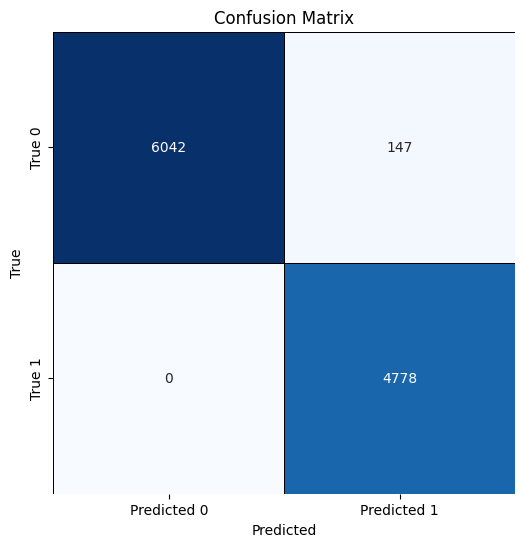

In [44]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_predict)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black", square=True, cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Save the model

In [45]:
with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

# XGboost without the scaled data

First we make a new data set. We make X and y, make sure y is o,1 because thats wht XGBoost understands for binary classification

In [46]:
# Suppress FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

X = df.drop('action_taken', axis=1)
y = df['action_taken']

# Replace values in the target variable 'y'
y = y.replace(3, 0)  # Replace 3 with 1
# Replace values in the target variable 'y'
y = y.replace(1, 1)  # Replace 3 with 1

X 

,loan_type,lien_status,open_end_line_of_credit,loan_amount,combined_loan_to_value_ratio,interest_rate,total_loan_costs,origination_charges,loan_term,negative_amortization,...,applicant_ethnicity_1,co_applicant_ethnicity_1,applicant_race_1,applicant_race_2,co_applicant_race_1,co_applicant_race_2,applicant_sex,co_applicant_sex,applicant_age,co_applicant_age
0,3,1,2,205000,16,5.0,7.0,1.0,6.0,2,...,2.0,2.0,5.0,5.0,5.0,5.0,1,2,7,4
1,2,1,2,155000,7,5.0,7.0,1.0,6.0,2,...,2.0,2.0,5.0,5.0,5.0,5.0,2,1,3,3
2,2,1,2,125000,8,5.0,7.0,1.0,6.0,2,...,2.0,2.0,5.0,5.0,5.0,5.0,1,2,4,3
3,2,1,2,55000,7,5.0,7.0,1.0,6.0,2,...,2.0,2.0,3.0,5.0,3.0,5.0,1,2,2,2
4,1,1,2,345000,1,5.0,7.0,1.0,3.0,2,...,2.0,2.0,5.0,5.0,5.0,5.0,1,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54827,1,1,2,285000,1,4.0,7.0,1.0,4.0,2,...,2.0,2.0,5.0,5.0,5.0,5.0,1,2,1,1
54828,1,1,2,225000,12,5.0,3.0,3.0,3.0,2,...,2.0,2.0,5.0,5.0,5.0,5.0,2,1,4,7
54829,1,1,2,1025000,1,4.0,11.0,1.0,6.0,2,...,2.0,2.0,5.0,5.0,5.0,5.0,2,1,3,3
54830,1,1,2,405000,2,6.0,9.0,1.0,6.0,2,...,2.0,2.0,5.0,5.0,5.0,5.0,1,2,1,1


In [47]:
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Split X_train and y_train into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [48]:
# Define and initialize the XGBoost classifier
xgb_model2 = XGBClassifier(**params, early_stopping_rounds=3)

# Set the validation dataset for early stopping
eval_set2 = [(X_val, y_val)]

# Train the model and monitor early stopping
xgb_model2.fit(X_train, y_train, eval_set=eval_set2, verbose=True)

# Make predictions on the test set
y_predict2 = (xgb_model2.predict_proba(X_test)[:, 1] >= 0.59)

# Calculate precision and recall on the test set
precision2 = precision_score(y_test, y_predict2)
recall2 = recall_score(y_test, y_predict2)

# Print test set results
print("Test set results:")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

from sklearn.metrics import accuracy_score, f1_score

# Calculate other evaluation metrics
accuracy2 = accuracy_score(y_test, y_predict2)
f12 = f1_score(y_test, y_predict2)

# Calculate the confusion matrix
cm2 = confusion_matrix(y_test, y_predict2)

# Print other evaluation metrics
print("Test set results:")
print(f"Precision: {precision2:.4f}")
print(f"Recall: {recall2:.4f}")
print(f"Accuracy: {accuracy2:.4f}")
print(f"F1 Score: {f12:.4f}")
print("Confusion Matrix:")
print(cm2)

[0]	validation_0-logloss:0.48830
[1]	validation_0-logloss:0.38185
[2]	validation_0-logloss:0.27772
[3]	validation_0-logloss:0.24530
[4]	validation_0-logloss:0.19299
[5]	validation_0-logloss:0.17112
[6]	validation_0-logloss:0.14029
[7]	validation_0-logloss:0.11994
[8]	validation_0-logloss:0.10667
[9]	validation_0-logloss:0.09748
[10]	validation_0-logloss:0.09024
[11]	validation_0-logloss:0.08512
[12]	validation_0-logloss:0.08165
[13]	validation_0-logloss:0.07828
[14]	validation_0-logloss:0.07582
[15]	validation_0-logloss:0.07402
[16]	validation_0-logloss:0.07194
[17]	validation_0-logloss:0.07042
[18]	validation_0-logloss:0.06928
[19]	validation_0-logloss:0.06799
[20]	validation_0-logloss:0.06667
[21]	validation_0-logloss:0.06608
[22]	validation_0-logloss:0.06549
[23]	validation_0-logloss:0.06476
[24]	validation_0-logloss:0.06419
[25]	validation_0-logloss:0.06370
[26]	validation_0-logloss:0.06310
[27]	validation_0-logloss:0.06268
[28]	validation_0-logloss:0.06241
[29]	validation_0-loglos

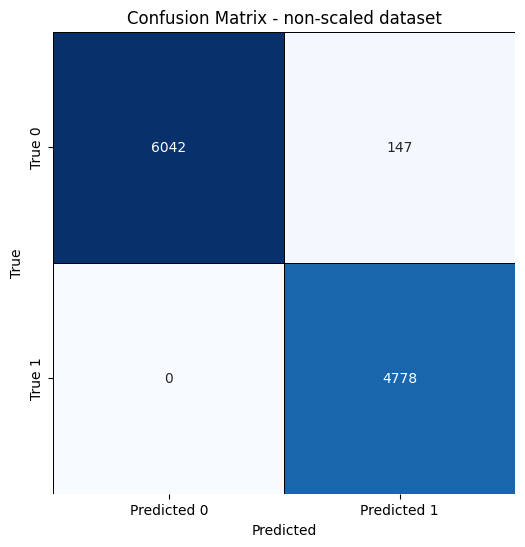

In [49]:
# Calculate the confusion matrix
cm2 = confusion_matrix(y_test, y_predict2)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5, linecolor="black", square=True, cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - non-scaled dataset")
plt.show()

In [51]:
# Make predictions on the test set
y_prob2 = xgb_model2.predict_proba(X_test)[:, 1]

# Calculate and print the classification report
report = classification_report(y_test, (y_prob2 > 0.5).astype(int), zero_division=1)
print(report)

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_prob2)
print("AUC-ROC:", roc_auc)

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_prob2, pos_label=1)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4778
           1       1.00      0.98      0.99      6189

    accuracy                           0.99     10967
   macro avg       0.99      0.99      0.99     10967
weighted avg       0.99      0.99      0.99     10967

AUC-ROC: 0.9966205282857465
Precision-Recall AUC: 0.9977851681433308


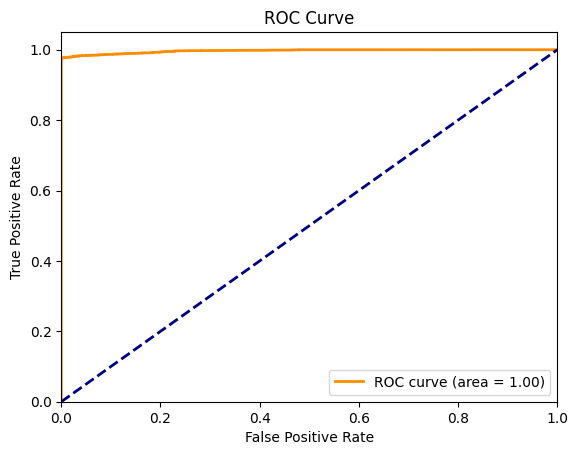

In [52]:
# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR)
fpr, tpr, _ = roc_curve(y_test, y_prob2, pos_label=1)

# Calculate AUC-ROC
roc_auc = auc(fpr, tpr)

# Create the ROC curve plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()